In [4]:
import cv2 as cv
from PIL import Image
import numpy as np 
from PIL import ImageGrab
import os
import requests as req
#from imageai.Detection import ObjectDetection
import mediapipe as mp
import face_recognition
from datetime import datetime
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score,precision_recall_curve,average_precision_score,log_loss,classification_report,cohen_kappa_score
import PIL.Image
import scikitplot as skplt
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import Augmentor
from lazypredict.Supervised import LazyClassifier
import pandas as pd
import seaborn as sns


In [13]:
HOGCV = cv.HOGDescriptor()
HOGCV.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())


pedestrian_cascade = cv.CascadeClassifier('haarcascade_fullbody.xml')

mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils

protopath = "MobileNetSSD_deploy.prototxt"
modelpath = "MobileNetSSD_deploy.caffemodel"
detector = cv.dnn.readNetFromCaffe(prototxt=protopath, caffeModel=modelpath)

CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]


In [14]:
def Find_Encodings(Images):
    encode_list = []
    for image in Images:
        image = cv.cvtColor(image,code = cv.COLOR_BGR2RGB)
        encodings = face_recognition.face_encodings(image)[0] 
        encode_list.append(encodings)
    return encode_list

In [15]:
#Face Recognition
path = 'ImageRecognition/'
Images = []
ClassNames = []
my_list = os.listdir(path)
print(my_list)
for cl in my_list:
    image = cv.imread(f'{path}/{cl}')
    Images.append(image)
    ClassNames.append(os.path.splitext(cl)[0])

encode_list_known = Find_Encodings(Images)

['Dhanush.jpg', 'Nevin.jpg', 'Vishnu.jpg']


In [16]:
def MotionDetector():
    framecount = 0
    prev_frame = None
    cap = cv.VideoCapture(0)
    
    with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
        while True:
            framecount += 1
        
            ret,img_bgr = cap.read()
            img_rgb = cv.cvtColor(img_bgr,code = cv.COLOR_BGR2RGB) 
            
        
            if((framecount%2) == 0):
                grayscale = cv.cvtColor(img_rgb,code = cv.COLOR_RGB2GRAY)
                grayscale = cv.GaussianBlur(grayscale,ksize = (5,5),sigmaX = 0)
                #grayscale_output
                #cv.imshow('Grayscale',grayscale)
                #cv.waitKey(0)
            
                if(prev_frame is None):
                    prev_frame = grayscale
                    continue
            
                dff_frame = cv.absdiff(src1 = prev_frame,src2 = grayscale)
                prev_frame = grayscale
        
                kernel = np.ones((100,100))
                dff_frame = cv.dilate(dff_frame,kernel,1)
            
                thresh_frame = cv.threshold(dff_frame,thresh = 100,maxval = 255,type = cv.THRESH_BINARY)[1]
                contours, _ = cv.findContours(image=thresh_frame,mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_SIMPLE)
                if(len(contours) >= 1):
                    #img_rgb = Object_detection_1(img_rgb)
                    img_rbg = ResizeWithAspectRatio(img_rgb,height = 800)
                    results = pose.process(img_rgb)
                    landmarks = results.pose_landmarks
                    pose_array = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
                    pose_array = pose_array.reshape(132,1)
                    mp_draw.draw_landmarks(img_rgb, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                    mp_draw.DrawingSpec((255, 0, 0), 2, 2),
                    mp_draw.DrawingSpec((255, 0, 255), 2, 2)
                    )
                    img_rgb_copy = Face_recognition(img_rgb)
                    is_cheat = Cheating_detection(pose_array)
                    position = val_list.index(is_cheat)
                    cv.putText(img_rgb,key_list[position],(30,30),cv.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
                    cv.imshow("Contors",img_rgb)
                    file_name = f'Detected_Motion/{framecount}.jpg'
                    cv.imwrite(file_name,img_rgb)
                    cv.waitKey(1)  
        

In [17]:
def Face_recognition(img_rgb):
    FaceCurrFrame = face_recognition.face_locations(img_rgb)
    EncodeCurrFrame = face_recognition.face_encodings(img_rgb,FaceCurrFrame)   
    for encodeFace,faceLoc in zip(EncodeCurrFrame,FaceCurrFrame):
        matches = face_recognition.compare_faces(encode_list_known,encodeFace)
        FaceDis = face_recognition.face_distance(encode_list_known,encodeFace)
        MatchIndex = np.argmin(FaceDis)
        if matches[MatchIndex]:
            name = ClassNames[MatchIndex].upper()
            x1,y1,x2,y2 = faceLoc
            cv.putText(img_rgb,name,(x1-10,y1-10),cv.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
            Mark_Student(name)
    return img_rgb

In [18]:
def Mark_Student(name):
    with open('Marked_Students.csv','r+') as f:
        myDataList = f.readlines()
        nameList = []
        for line in myDataList:
            entry = line.split(',')
            nameList.append(entry[0])
        if name not in nameList:
            now = datetime.now()
            dstring = now.strftime('%H:%M:%S')
            f.writelines(f'\n{name},{dstring}')

In [19]:
#primitive object detection 
def Object_detection(img_src):
    bounding_box_cordinates, weights =  HOGCV.detectMultiScale(img_src, winStride = (4, 4), padding = (8, 8), scale = 1.03)
    #bounding_box_cordinates = pedestrian_cascade.detectMultiScale( img_src, 1.1, 1)
    person = 1
    for x,y,w,h in bounding_box_cordinates:
        cv.rectangle(img_src, (x,y), (x+w,y+h), (0,255,0), 2)
        cv.putText(img_src, f'person {person}', (x,y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
        person += 1
    
    #cv2.putText(frame, 'Status : Detecting ', (40,40), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,0,0), 2)
    #cv2.putText(frame, f'Total Persons : {person-1}', (40,70), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,0,0), 2)
    return img_src
    
    
    

In [20]:
#advanced object detection
def Object_detection_1(img_src):
    (H, W) = img_src.shape[:2]
    blob = cv.dnn.blobFromImage(img_src, 0.007843, (W, H), 127.5)

    detector.setInput(blob)
    person_detections = detector.forward()

    for i in np.arange(0, person_detections.shape[2]):
        confidence = person_detections[0, 0, i, 2]
        if confidence > 0.5:
            idx = int(person_detections[0, 0, i, 1])

            if CLASSES[idx] != "person":
                continue

            person_box = person_detections[0, 0, i, 3:7] * np.array([W, H, W, H])
            (startX, startY, endX, endY) = person_box.astype("int")
            (startX, startY, endX, endY) = (startX, startY, endX, endY)

            cv.rectangle(img_src, (startX , startY ), (endX , endY ), (0, 0, 255), 2)
    return img_src

In [21]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv.resize(image, dim, interpolation=inter)

In [29]:
image_1 = cv.imread('.\Keypoints dataset\Back\Back_original_turning_back_2.jpg_1e3ec447-ba96-4c74-8971-74e320bcef0a.jpg')
image_1 = ResizeWithAspectRatio(image_1, height = 800)
print(image_1.shape)

cv.imshow("Output",image_1)
cv.waitKey(1000)
with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence = 0.3) as pose:
        results = pose.process(image_1)
        landmarks = results.pose_landmarks
        pose_array = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
        print(pose_array.shape)
        mp_draw.draw_landmarks(image_1, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        mp_draw.DrawingSpec((255, 0, 0), 2, 2),
        mp_draw.DrawingSpec((255, 0, 255), 2, 2)
        )
        cv.imshow("Output",image_1)
        cv.waitKey(1000)

(800, 1066, 3)
(132,)


In [20]:
cap = cv.VideoCapture("IMG-0730.mp4")
data = []
while True: 
    ret,img_bgr = cap.read()
    if ret:
        image = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY)
        img_resized = cv.resize(image,(28,28))
        img_array = img_to_array(img_resized)
        data.append(img_array)
    else:
        break
    #cv.imshow("Output",image_1)
    #cv.waitKey(1000)


In [11]:
path_to_dataset = './Keypoints dataset/'

img_dir = []#get the directory of the image folders
for entry in os.scandir(path_to_dataset):
    if entry.is_dir():
        img_dir.append(entry.path)
        

In [12]:
path_to_dataset_back = './KeyPoints_Copy/Back - Copy'
path_to_dataset_left = './KeyPoints_Copy/Left - Copy'
path_to_dataset_right = './KeyPoints_Copy/Right - Copy'
path_to_dataset_down = './KeyPoints_Copy/Down - Copy'
path_to_dataset_hand = './KeyPoints_Copy/Hand - Copy/'
path_to_dataset_normal = './KeyPoints_Copy/Normal - Copy/'

path_to_new_dataset = './New_Dataset/'

In [72]:
#augmentor
def get_samples(path):

    no_of_samples = 20

    A_1 = Augmentor.Pipeline(path)
    A_1.random_distortion(probability = 1, grid_width = 4, grid_height = 4, magnitude = 4)
    A_1.sample(no_of_samples)

In [116]:
# get_samples(path_to_dataset_back)
# get_samples(path_to_dataset_left)
# get_samples(path_to_dataset_right)
# get_samples(path_to_dataset_down)
# get_samples(path_to_dataset_hand)
# get_samples(path_to_dataset_normal)

#get_samples(path_to_new_dataset)

In [13]:
celebrity_file_name_dict = {}

for images_path in img_dir:
    celebrity_file_name_dict[images_path.split('/')[-1]] = []
    for images in os.scandir(images_path):
        print(images.path)
        celebrity_file_name_dict[images_path.split('/')[-1]].append(images.path)
    
len(celebrity_file_name_dict['Hand'])

./Keypoints dataset/Back\Back_original_turning_back_1.jpg_0a8c9332-d9dc-4618-aeff-85d0b5838f79.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1784d819-43de-43ae-8a80-dd99fd691718.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1b665967-c542-4328-9196-77d440f25dc9.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1dd98e4c-a4cd-431d-9275-fe5a31b67299.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1e1edd23-be8a-4015-9ffe-25daa6b5d886.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_24bb4452-3932-404d-b2ca-26787c3211c1.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_29ff84dc-6f91-4c92-b949-9c5b551d5fdb.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_2d7cb329-5a01-4c4a-bc14-baa72cf7f368.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_32f93e58-3833-4fd6-8936-fbbcb9f94ca7.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_35f42893-a2d6-4cb8-b736-b0342fc64245.jpg
./Keypoint

102

In [14]:
celebrity_class_dict = {}
count_1 = 0

for x in celebrity_file_name_dict.keys():
    celebrity_class_dict[x] = count_1
    count_1+=1
print(celebrity_class_dict)
val_list = list(celebrity_class_dict.values())
key_list = list(celebrity_class_dict.keys())

{'Back': 0, 'Down': 1, 'Hand': 2, 'Left': 3, 'Normal': 4, 'Right': 5}


In [15]:
X = []
y = []


for celebrity_names,image_pos in celebrity_file_name_dict.items():
    print(celebrity_names)
    for image_poss in image_pos:
        try:
            img = cv.imread(image_poss)
            scalled_img = ResizeWithAspectRatio(img,height = 800)
            with mp_pose.Pose(min_detection_confidence=0.3,min_tracking_confidence = 0.3) as pose:
                results = pose.process(scalled_img)
                landmarks = results.pose_landmarks
                print(image_poss)
                pose_array = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
                pose_array = pose_array.reshape(132,1)
                X.append(pose_array)
                y.append(celebrity_class_dict[celebrity_names])
                mp_draw.draw_landmarks(scalled_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                mp_draw.DrawingSpec((255, 0, 0), 2, 2),
                mp_draw.DrawingSpec((255, 0, 255), 2, 2)
                )
        except:
            continue
        #cv.imshow('open',scalled_img)
        #cv.waitKey(1000)

Back
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_0a8c9332-d9dc-4618-aeff-85d0b5838f79.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1784d819-43de-43ae-8a80-dd99fd691718.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1b665967-c542-4328-9196-77d440f25dc9.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1dd98e4c-a4cd-431d-9275-fe5a31b67299.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_1e1edd23-be8a-4015-9ffe-25daa6b5d886.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_24bb4452-3932-404d-b2ca-26787c3211c1.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_29ff84dc-6f91-4c92-b949-9c5b551d5fdb.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_2d7cb329-5a01-4c4a-bc14-baa72cf7f368.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_32f93e58-3833-4fd6-8936-fbbcb9f94ca7.jpg
./Keypoints dataset/Back\Back_original_turning_back_1.jpg_35f42893-a2d6-4cb8-b736-b0342fc64245.jpg
./Key

./Keypoints dataset/Back\Back_original_turning_back_2.jpg_b0118652-0b43-42b1-9b0e-377f3f24b6e9.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_b09beabb-5683-4b88-b047-cc9cf8d74433.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_b3c7b780-b2f6-43ff-b3de-34805c0a40e3.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_b853ef2d-e951-4742-9dcc-e2b81a61bd32.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_c94dcc5f-e8c1-4b5c-8440-7944feb25daa.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_d1f5f272-54f4-4d9d-857d-ebc004357378.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_d6fd378d-4693-4281-a4f3-749b1e4a3a3e.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_de53df65-1872-4fb7-b0de-71a008438cd7.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_e11725c2-daaf-41be-81c9-c7c419916acd.jpg
./Keypoints dataset/Back\Back_original_turning_back_2.jpg_e132d123-bf99-4ec8-9f09-9e5c83726547.jpg
./Keypoint

./Keypoints dataset/Down\Down_original_looking_down_3.jpg_ea226ad6-7990-4cab-bcdc-6d8badf07634.jpg
./Keypoints dataset/Down\Down_original_looking_down_3.jpg_f7a58170-ccf2-4c2a-85e1-ce1b1260aa86.jpg
./Keypoints dataset/Down\Down_original_looking_down_3.jpg_f95948ea-e807-4543-90d4-7aec843f1fd1.jpg
./Keypoints dataset/Down\Down_original_looking_down_3.jpg_fd04454b-51f0-4a18-891b-4bf412d94659.jpg
./Keypoints dataset/Down\Down_original_look_down_1.jpg_0e45efeb-6a5e-47cb-8020-756b2c45f3d2.jpg
./Keypoints dataset/Down\Down_original_look_down_1.jpg_160454fc-8df6-4b43-b306-9a03b1deba33.jpg
./Keypoints dataset/Down\Down_original_look_down_1.jpg_2492842a-2ee0-4098-afa7-8cc4e5f0d34e.jpg
./Keypoints dataset/Down\Down_original_look_down_1.jpg_252c620b-34e6-413d-ac15-140f184ecb12.jpg
./Keypoints dataset/Down\Down_original_look_down_1.jpg_2584bdbb-a375-4cf1-964c-9ecfec4abd92.jpg
./Keypoints dataset/Down\Down_original_look_down_1.jpg_27ef2985-1b3d-47f8-b05e-30ad59f7b63e.jpg
./Keypoints dataset/Down\Dow

./Keypoints dataset/Hand\Hand_original_looking_hand_1.jpg_fb5c2281-b7cb-42eb-b07a-fae9680b03c2.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_03dc0de3-6462-4592-bbb2-e9f548d2c7f5.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_0be18417-7f91-4808-8743-d38a9666410d.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_0d0e3ebc-69e8-4186-9f4e-709eedfdf0cc.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_0e5c2b98-f5a2-4a88-8b58-cc2915e499c9.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_0e912dbf-a427-42cf-8d80-029c445a9ace.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_0fecd7f3-db60-40d7-8606-782515b311ec.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_151aecda-747f-4dcb-9f6e-327c88d57dbd.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_190e7775-c0ce-4f04-a927-cb6f7d5bf4ca.jpg
./Keypoints dataset/Hand\Hand_original_looking_hand_2.jpg_22a6dafb-42ea-4076-859a-d84fb2acfe82.jpg
./Keypoint

./Keypoints dataset/Left\Left_original_hand_left_2.jpg_c6e31def-0e1c-476a-845a-4cca27ea1622.jpg
./Keypoints dataset/Left\Left_original_hand_left_2.jpg_c6fb06ac-6bed-47f2-8234-4bf99ed22760.jpg
./Keypoints dataset/Left\Left_original_hand_left_2.jpg_e3b99b1e-d291-4244-a06a-89e0ffa4dbbb.jpg
./Keypoints dataset/Left\Left_original_looking_sideways_2.jpg_0245b392-bdb5-4ada-b88f-7560804780e8.jpg
./Keypoints dataset/Left\Left_original_looking_sideways_2.jpg_147fb91f-d341-47a4-8fe3-e07fc52ae5e6.jpg
./Keypoints dataset/Left\Left_original_looking_sideways_2.jpg_1f53bb38-55f6-49ea-ac34-b235ea5ec8a7.jpg
./Keypoints dataset/Left\Left_original_looking_sideways_2.jpg_2c807cc0-81d6-48e5-8f9e-db2283ff17a1.jpg
./Keypoints dataset/Left\Left_original_looking_sideways_2.jpg_34ac6cc0-7a86-4675-8c68-1934c3dd0270.jpg
./Keypoints dataset/Left\Left_original_looking_sideways_2.jpg_35799d64-1e63-43ad-b661-e9fd29177b41.jpg
./Keypoints dataset/Left\Left_original_looking_sideways_2.jpg_383078ca-e3db-405c-b850-e755397d

./Keypoints dataset/Normal\Normal_original_normal_1.jpg_9c861dfd-4c6f-4e33-a15a-ed8c73e4df14.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_9d85bfb5-5738-4032-9618-5f1970cadca5.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_a1200d28-d315-4da1-81e6-23f7355d3f52.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_a8c6e584-d272-4d66-85de-123658eec4f2.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_aa1cfd51-54f9-41e2-afc9-1feac40563f4.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_aecfc3f4-c0a5-452a-bed8-e5937d80948d.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_b00e78d7-35e5-46f8-8ed2-b6ddecc99aac.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_d07fbc2d-63da-48c2-983b-6d1c24b9dd46.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_e8100300-80de-451a-a18a-7daf83ab4b84.jpg
./Keypoints dataset/Normal\Normal_original_normal_1.jpg_f8cf410a-2828-48ea-8ae6-cd8ad3c1e7b6.jpg
./Keypoints dataset/Normal\Nor

./Keypoints dataset/Normal\Normal_original_normal_6.jpg_7bf51f27-16ff-496b-9939-be4a0351d9e7.jpg
./Keypoints dataset/Normal\Normal_original_normal_6.jpg_8a2fffde-d67b-4ef5-a9d7-7ce3b4dfc3ed.jpg
./Keypoints dataset/Normal\Normal_original_normal_6.jpg_98de2473-9679-4d8a-938d-c8333b8ef651.jpg
./Keypoints dataset/Normal\Normal_original_normal_6.jpg_c0619b24-5430-495d-8bc5-550395b1818e.jpg
./Keypoints dataset/Normal\Normal_original_normal_6.jpg_e9a8764e-236c-42a2-badd-6e76b1a4f1ba.jpg
./Keypoints dataset/Normal\Normal_original_normal_6.jpg_f00d521a-a4ea-4d88-bcdd-6773a53fe80a.jpg
./Keypoints dataset/Normal\Normal_original_normal_6.jpg_f1324182-5aee-476b-85c2-20af85f3f65f.jpg
Right
./Keypoints dataset/Right\20221013_234841.jpg
./Keypoints dataset/Right\20221013_234851.jpg
./Keypoints dataset/Right\20221013_234930.jpg
./Keypoints dataset/Right\hand_right_2.jpg
./Keypoints dataset/Right\looking_sideways_1.jpg
./Keypoints dataset/Right\Right_original_20221013_234841.jpg_0cb22243-c477-4b61-bdb0-

./Keypoints dataset/Right\Right_original_turning right_1.jpg_4163c433-d28d-4517-9105-6f0880cf6a13.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_42fe1994-34b8-4ceb-942e-d7d309800281.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_4c71f10a-921f-473c-bc3a-6703631adf68.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_8023360c-11df-4bf1-9f26-4e1d6c3594a8.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_8c82368d-1b62-461f-a2c6-3081dd5b5401.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_90e5ff10-97f8-42e6-b30e-c2c2cc6bb131.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_9f8981ce-abba-4c77-b892-069062858ae3.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_a72041d1-29a2-4289-bc6e-8c7f8ac0660e.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_ac219f59-adf2-4adf-bac6-45d98d32f878.jpg
./Keypoints dataset/Right\Right_original_turning right_1.jpg_adac926a-76c2-435d-b2

In [16]:
print(len(X))
X = np.array(X).reshape(len(X),132).astype(float)
X[0].shape

616


(132,)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size = 0.2)
X_train[0].shape

(132,)

In [23]:
#Linear Discriminant Analysis
# pipe = Pipeline([('scaler', StandardScaler()), ('kmeans',KNeighborsClassifier() )])
pipe = Pipeline([('scaler', StandardScaler()), ('LDA',LinearDiscriminantAnalysis(solver = 'svd') )])
#pipe = Pipeline([('scaler', StandardScaler()), ('Ridge Classifier',RidgeClassifierCV() )])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)
print(precision_score(y_test,y_pred,average = 'micro'))
print(recall_score(y_test,y_pred,average = 'micro'))
print(f1_score(y_test,y_pred,average = 'micro'))
print(roc_auc_score(y_test,y_pred_proba,average = 'macro',multi_class = 'ovo'))
pipe.score(X_train,y_train)
print(pipe.score(X_test,y_test))

0.9516129032258065
0.9516129032258065
0.9516129032258065
0.9973856209150326
0.9516129032258065


In [19]:
#Ridge classifier
# pipe = Pipeline([('scaler', StandardScaler()), ('kmeans',KNeighborsClassifier() )])
#pipe = Pipeline([('scaler', StandardScaler()), ('LDA',LinearDiscriminantAnalysis(solver = 'svd') )])
pipe_1 = Pipeline([('scaler', StandardScaler()), ('Ridge Classifier',RidgeClassifierCV() )])
pipe_1.fit(X_train, y_train)
y_pred_1 = pipe_1.predict(X_test)
#y_pred_proba = pipe_1.predict(X_test)
print(precision_score(y_test,y_pred_1,average = 'micro'))
print(recall_score(y_test,y_pred_1,average = 'micro'))
print(f1_score(y_test,y_pred_1,average = 'micro'))
#print(roc_auc_score(y_test,y_pred_proba,average = 'macro',multi_class = 'ovo'))
print(pipe_1.score(X_train,y_train))
print(pipe_1.score(X_test,y_test))
#print(pipe_1.score(X_test,))
#print(y_pred_proba)

0.9274193548387096
0.9274193548387096
0.9274193548387096
0.9390243902439024
0.9274193548387096


In [24]:
#Support Vector Machi
# pipe = Pipeline([('scaler', StandardScaler()), ('kmeans',KNeighborsClassifier() )])
#pipe_2 = Pipeline([('scaler', StandardScaler()), ('SVM',SVC(probability = True))])
pipe_2 = Pipeline([('scaler', StandardScaler()), ('extra tree classifier',ExtraTreesClassifier())])
#pipe = Pipeline([('scaler', StandardScaler()), ('Ridge Classifier',RidgeClassifierCV() )])
pipe_2.fit(X_train, y_train)
y_pred_2 = pipe_2.predict(X_test)
y_pred_proba_2 = pipe_2.predict_proba(X_test)
print(precision_score(y_test,y_pred_2,average = 'micro'))
print(recall_score(y_test,y_pred_2,average = 'micro'))
print(f1_score(y_test,y_pred_2,average = 'micro'))
print(roc_auc_score(y_test,y_pred_proba_2,average = 'macro',multi_class = 'ovo'))
pipe_2.score(X_train,y_train)
print(pipe_2.score(X_test,y_test))

0.9596774193548387
0.9596774193548387
0.9596774193548389
0.9944346821049607
0.9596774193548387


124


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

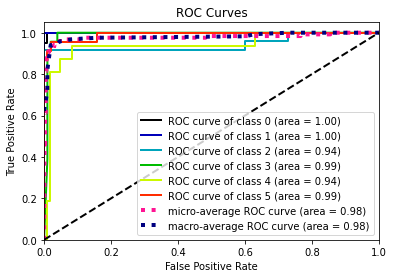

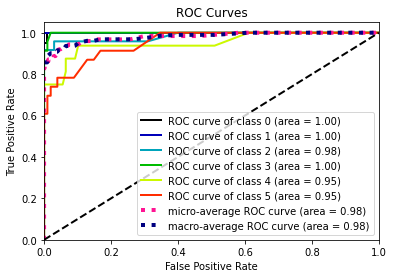

In [21]:
#ROC Curves
print(len(y_test))
skplt.metrics.plot_roc_curve(y_test,y_pred_proba)
skplt.metrics.plot_roc_curve(y_test,y_pred_proba_2)

In [26]:
#Classification Report
classificationreport = classification_report(y_test, y_pred)
print(classificationreport)
#sns.heatmap(classificationreport)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.97        19
           2       0.96      1.00      0.98        26
           3       0.91      1.00      0.95        21
           4       1.00      0.82      0.90        17
           5       0.90      0.90      0.90        20

    accuracy                           0.95       124
   macro avg       0.95      0.95      0.95       124
weighted avg       0.95      0.95      0.95       124



In [23]:
#cohen kappa score 
print(cohen_kappa_score(y_pred,y_pred_1))

0.8738654147104852


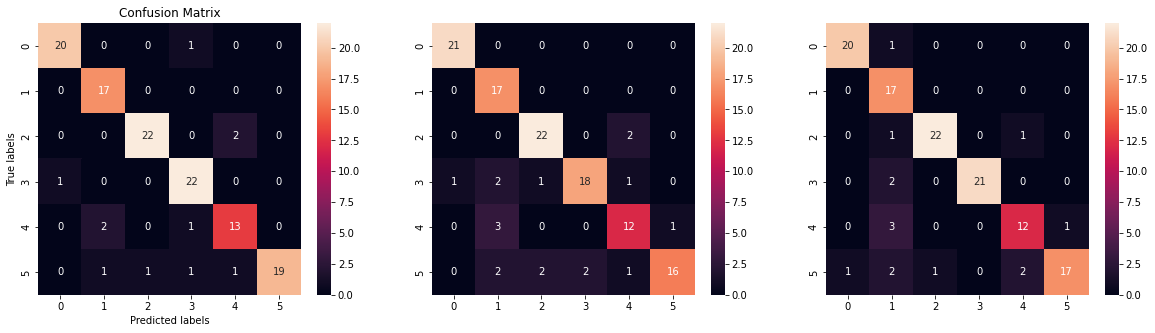

In [24]:
#Confusion Matrix
CM_1 = confusion_matrix(y_test,y_pred)
CM_2 = confusion_matrix(y_test,y_pred_1)
CM_3 = confusion_matrix(y_test,y_pred_2)

fig,ax1 = plt.subplots(1,3,figsize = (20,5))
sns.heatmap(CM_1,annot = True, fmt = 'g', ax = ax1[0]); 
sns.heatmap(CM_2,annot = True, fmt = 'g', ax = ax1[1]);
sns.heatmap(CM_3,annot = True, fmt = 'g', ax = ax1[2])

# labels, title and ticks
ax1[0].set_xlabel('Predicted labels'); 
ax1[0].set_ylabel('True labels'); 
ax1[0].set_title('Confusion Matrix'); 


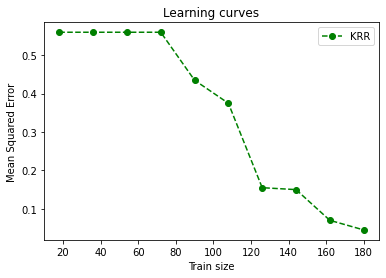

In [27]:
#Learning Curve
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    RidgeClassifierCV(),
    X[:200],
    y[:200],
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)

train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    ExtraTreesClassifier(),
    X[:100],
    y[:100],
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=10,
)

plt.plot(train_sizes, -test_scores_svr.mean(1), "o--", color="g", label="KRR")
#plt.plot(train_sizes_abs, -test_scores_kr.mean(1), "o--", color="r", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

In [21]:

lclas = LazyClassifier(verbose = 0,ignore_warnings = False,custom_metric = None)
models,prediction = lclas.fit(X_train,X_test,y_train,y_test)

models
print(prediction)

  3%|██▊                                                                                | 1/29 [00:00<00:16,  1.69it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')


  7%|█████▋                                                                             | 2/29 [00:00<00:12,  2.25it/s]

ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')


 24%|████████████████████                                                               | 7/29 [00:02<00:06,  3.52it/s]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')


 45%|████████████████████████████████████▊                                             | 13/29 [00:02<00:02,  7.41it/s]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LabelSpreading
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 52%|██████████████████████████████████████████▍                                       | 15/29 [00:03<00:02,  6.36it/s]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')


 66%|█████████████████████████████████████████████████████▋                            | 19/29 [00:03<00:01,  8.16it/s]

ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for NuSVC
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')


 72%|███████████████████████████████████████████████████████████▍                      | 21/29 [00:03<00:00,  9.28it/s]

ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 86%|██████████████████████████████████████████████████████████████████████▋           | 25/29 [00:04<00:00,  7.77it/s]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'
[21:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 28/29 [00:05<00:00,  5.80it/s]

ROC AUC couldn't be calculated for XGBClassifier
multi_class must be in ('ovo', 'ovr')


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:06<00:00,  4.77it/s]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
ExtraTreesClassifier               0.97               0.96    None      0.97   
LGBMClassifier                     0.96               0.96    None      0.96   
LabelSpreading                     0.96               0.96    None      0.96   
LabelPropagation                   0.96               0.96    None      0.96   
LinearSVC                          0.96               0.95    None      0.96   
LinearDiscriminantAnalysis         0.95               0.95    None      0.95   
CalibratedClassifierCV             0.95               0.94    None      0.95   
XGBClassifier                      0.94               0.94    None      0.94   
KNeighborsClassifier               0.94               0.94    None      0.94   
LogisticRegression              

In [29]:
def Cheating_detection(array_1):
    lst = []
    lst.append(array_1)
    lst = np.array(lst).reshape(len(lst),132).astype(float)
    print(array_1.shape)
    result = pipe.predict(lst)
#     result1 = pipe_1.predict(lst)
#     if(result1 == 3):
#         return str(result1)
#     else: 
#         return str(result)
    return result
    

In [ ]:
MotionDetector()

(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(132, 1)
(